In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from tqdm import tqdm  # Using standard tqdm for better notebook stability

# 1. Add project root to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# 2. Enable Autoreload
%load_ext autoreload
%autoreload 2

# 3. Import your custom modules
from src.dataset import CityscapesKaggleDataset
from src.model import UNet

print(f"✅ Success: Project root connected at {project_root}")

✅ Success: Project root connected at /Users/kaankoc/Projects/autovision-mps


In [2]:
# 1. Device Setup (macOS Optimized)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Hyperparameters
DATA_DIR = '../data/raw/cityscapes_data'
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
EPOCHS = 10  # Increased for better convergence on 7 classes

# 3. Initialize Dataset and Loader
train_ds = CityscapesKaggleDataset(root_dir=DATA_DIR, split='train')
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

# 4. Initialize Model (Updated for 7 classes), Loss, and Optimizer
model = UNet(n_channels=3, n_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"✅ Success: Model initialized to recognize 7 unique classes.")

Using device: mps
✅ Success: Model initialized to recognize 7 unique classes.


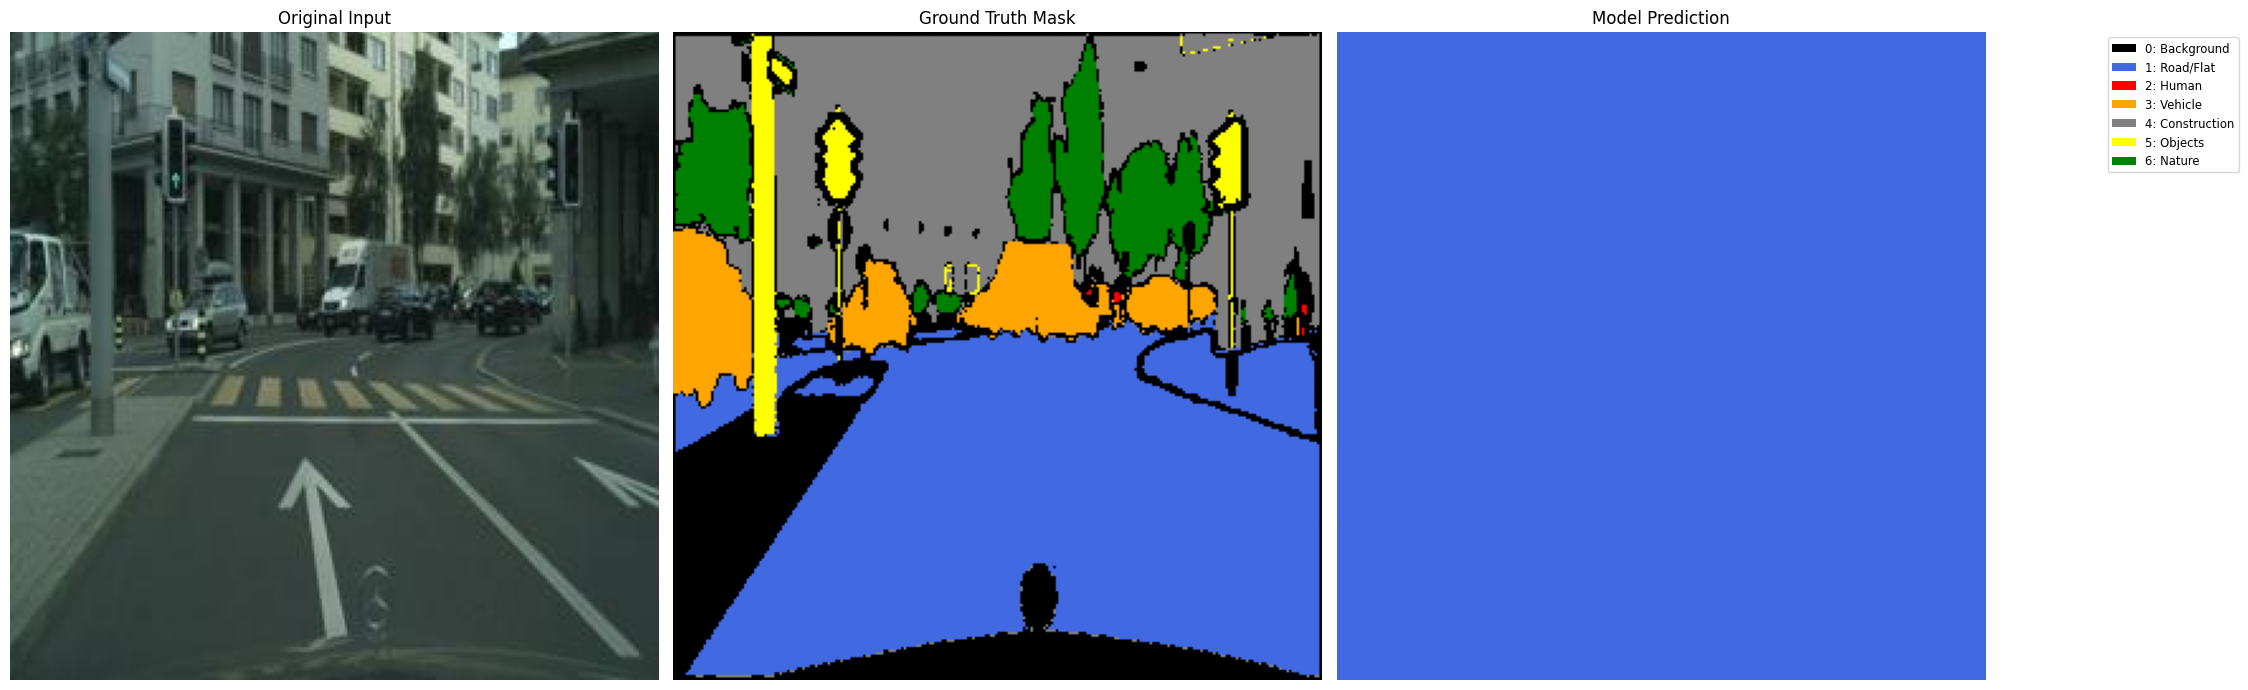

In [3]:
def visualize_prediction(model, dataset, index=10):
    model.eval()
    image, mask = dataset[index]
    
    # Setup Colors for the 7 classes (0-6)
    class_colors = ['black', 'royalblue', 'red', 'orange', 'gray', 'yellow', 'green']
    class_names = ['Background', 'Road/Flat', 'Human', 'Vehicle', 'Construction', 'Objects', 'Nature']
    custom_cmap = mcolors.ListedColormap(class_colors)
    
    # Add batch dimension and move to device
    input_tensor = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(22, 7))
    
    # 1. Input
    ax[0].imshow(image.permute(1, 2, 0).numpy())
    ax[0].set_title("Original Input")
    
    # 2. Ground Truth
    ax[1].imshow(mask.numpy(), cmap=custom_cmap, vmin=0, vmax=6)
    ax[1].set_title("Ground Truth Mask")
    
    # 3. Prediction
    im_pred = ax[2].imshow(prediction, cmap=custom_cmap, vmin=0, vmax=6)
    ax[2].set_title("Model Prediction")
    
    # Add Legend to the prediction panel
    legend_elements = [Patch(facecolor=class_colors[i], label=f'{i}: {class_names[i]}') 
                       for i in range(len(class_colors))]
    ax[2].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.4, 1.0), fontsize='small')

    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()

# Test visualization on an untrained model
visualize_prediction(model, train_ds, index=10)

Starting training for 10 epochs on mps...


✅ Epoch 1 Completed | Avg Loss: 0.8123


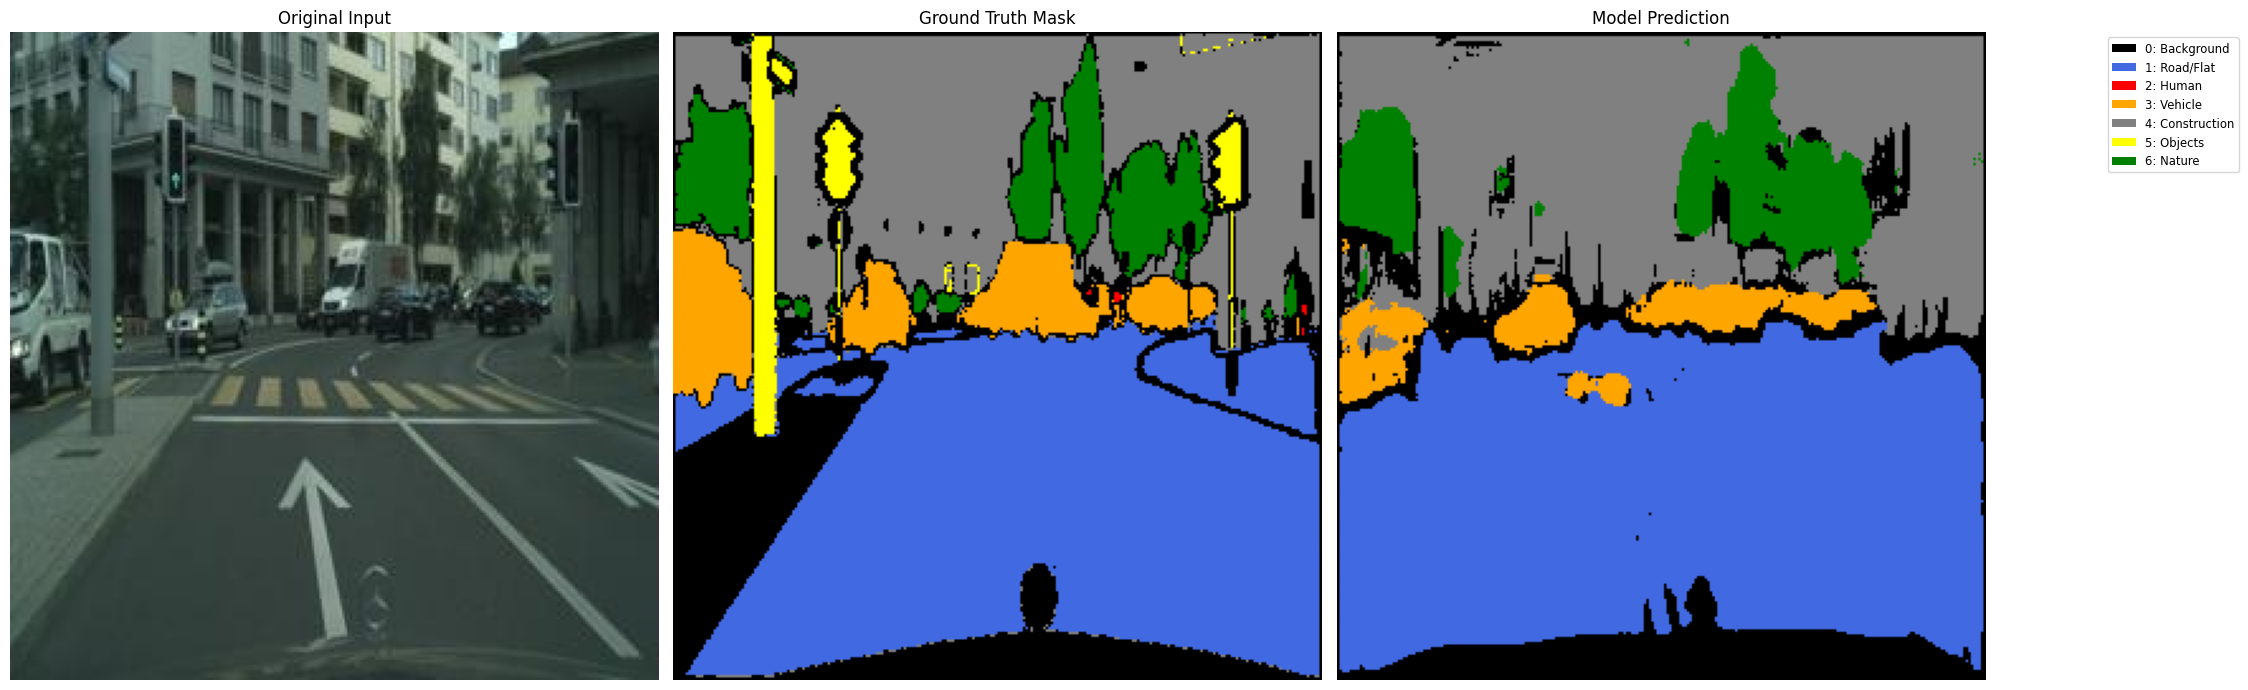

✅ Epoch 2 Completed | Avg Loss: 0.6243


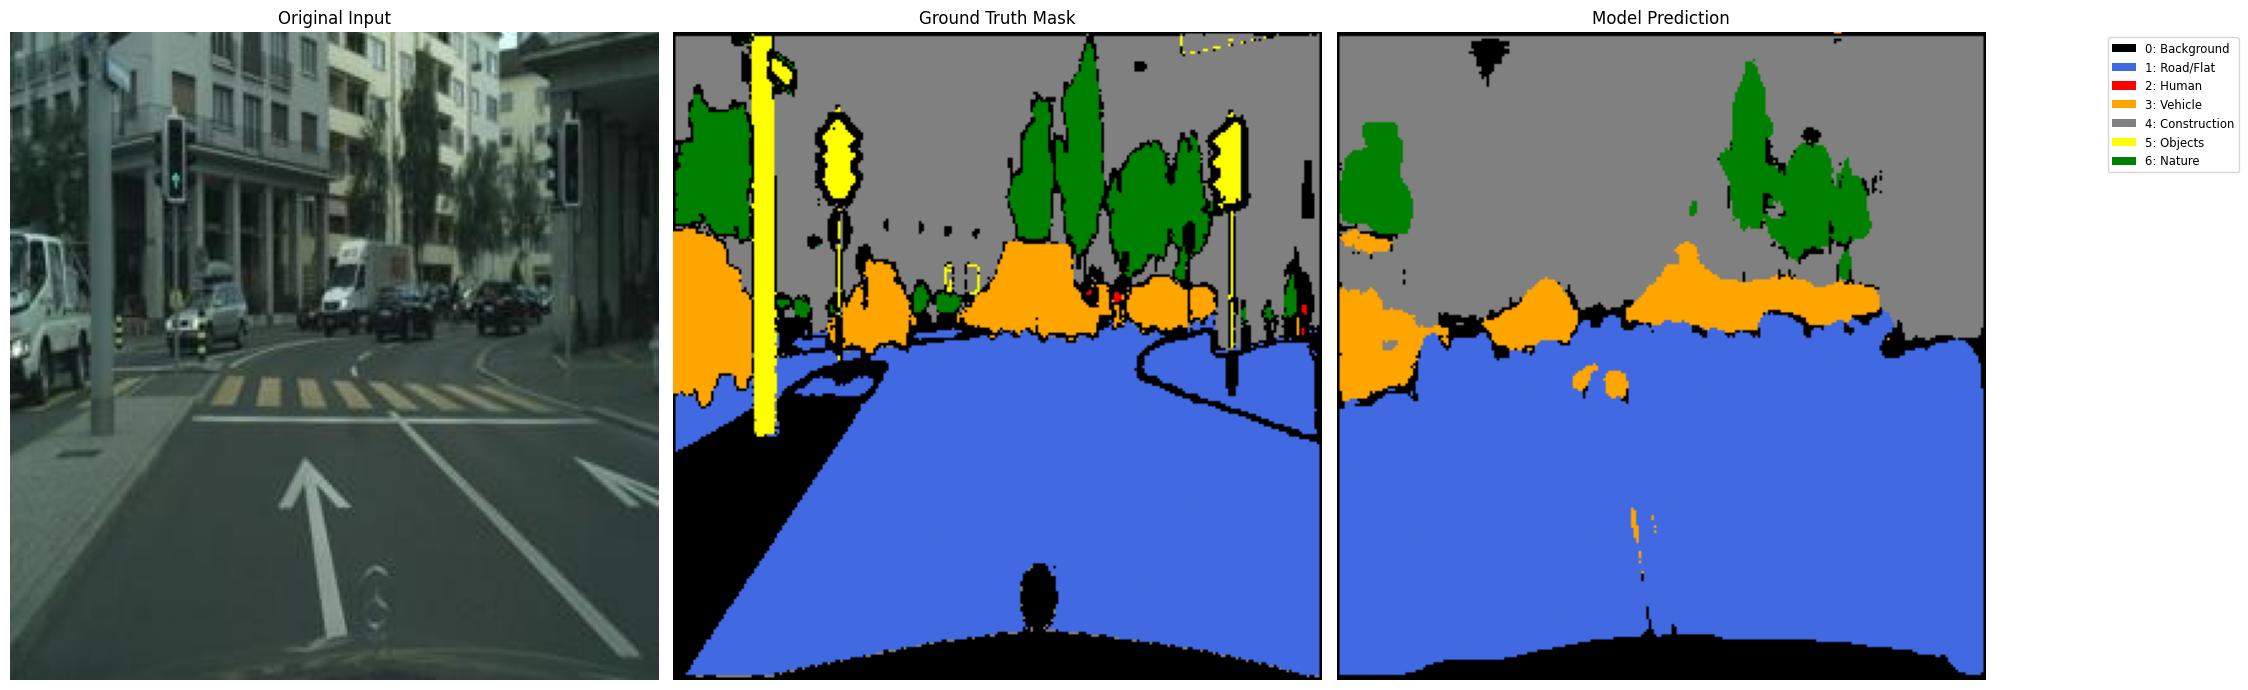

✅ Epoch 3 Completed | Avg Loss: 0.5084


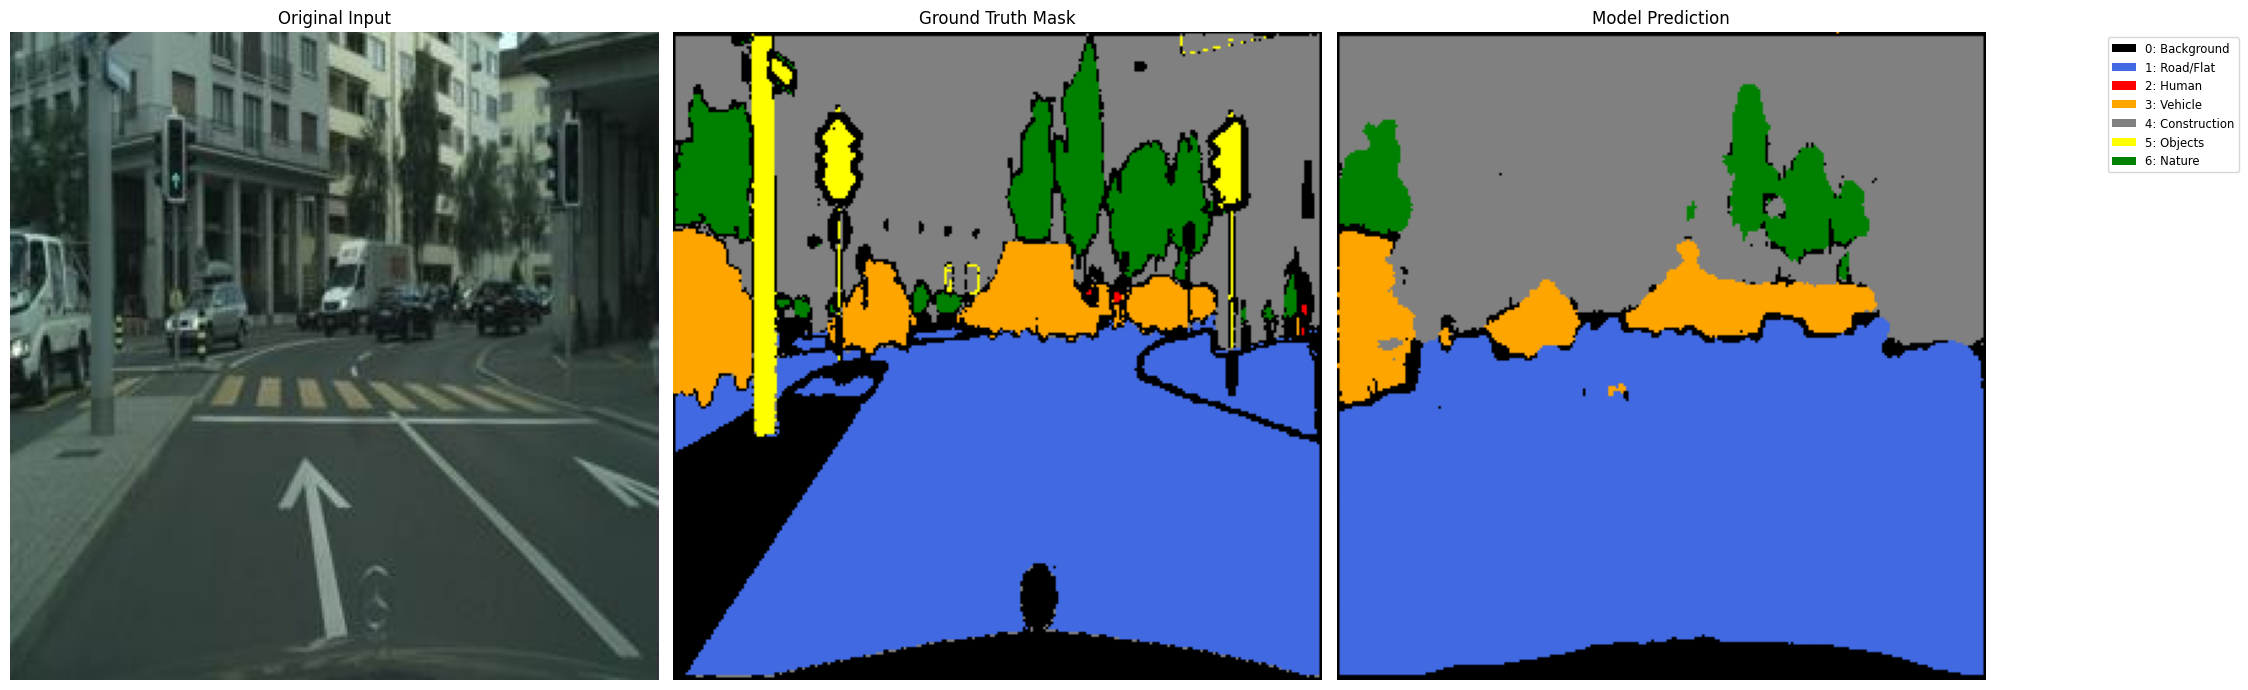

✅ Epoch 4 Completed | Avg Loss: 0.4753


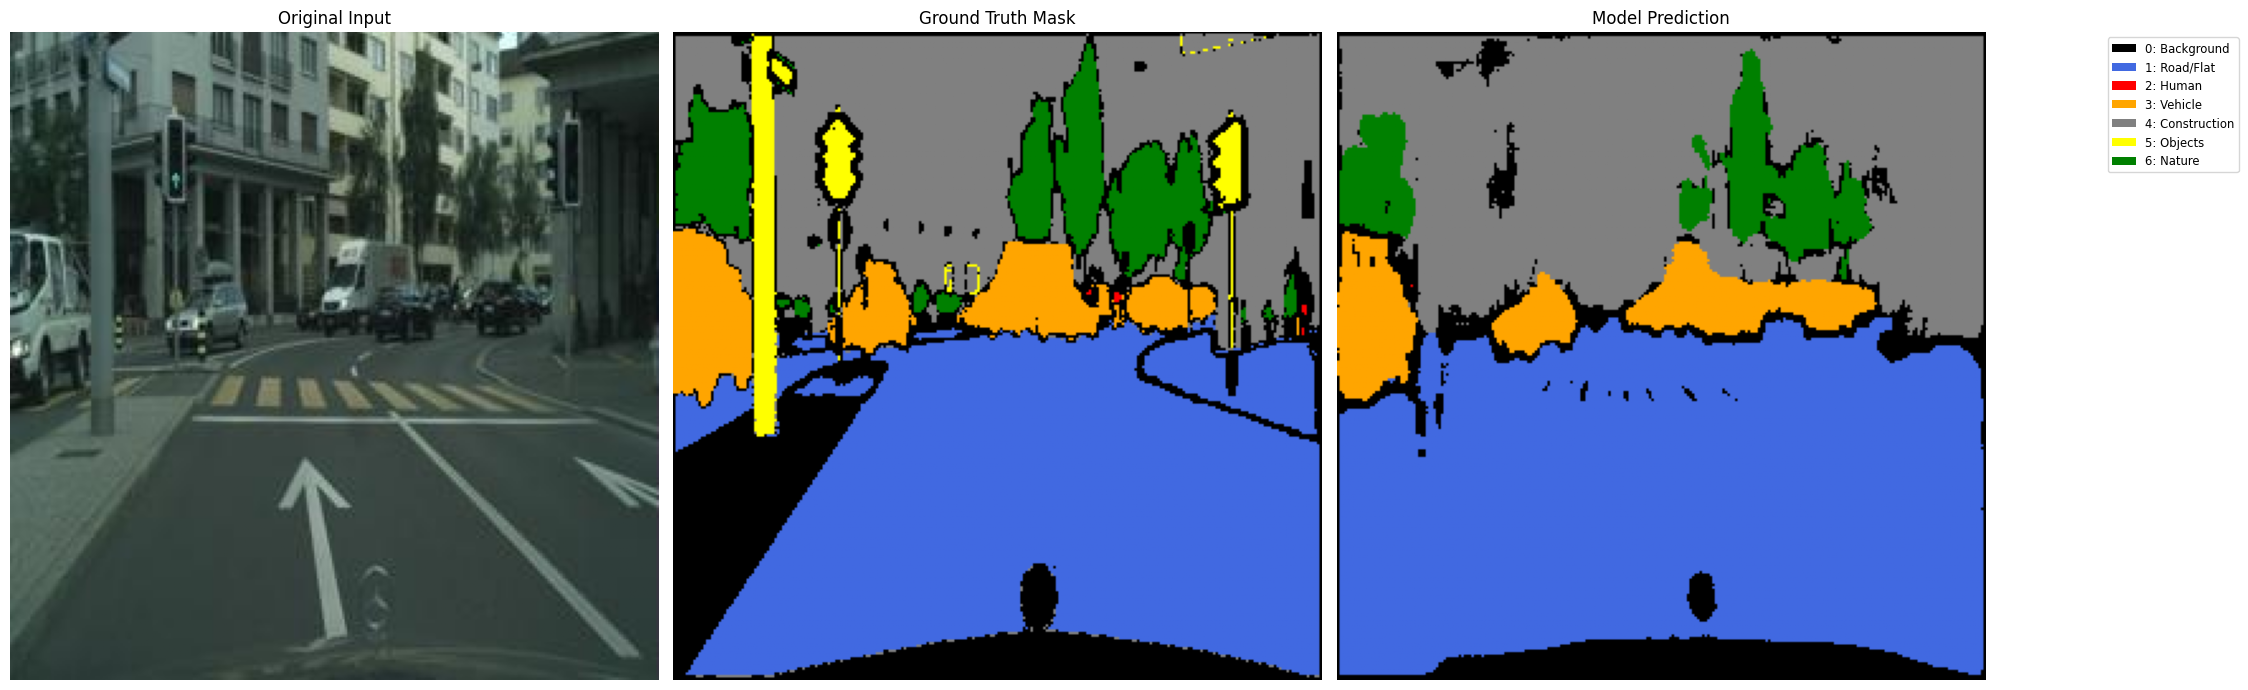

✅ Epoch 5 Completed | Avg Loss: 0.4507


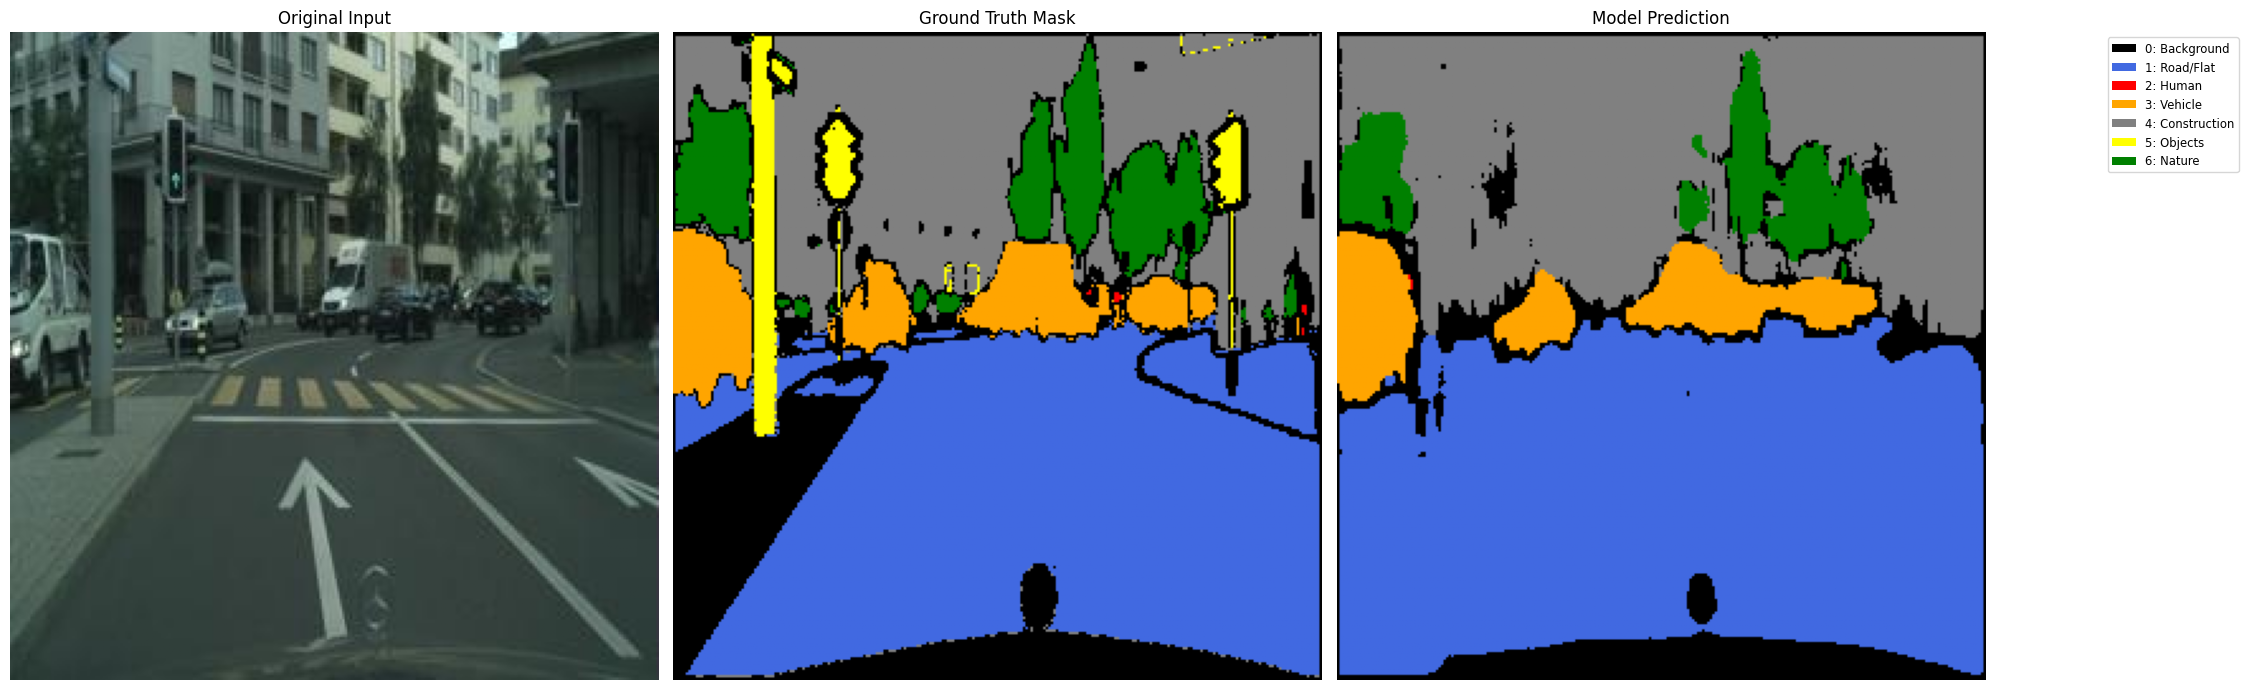

✅ Epoch 6 Completed | Avg Loss: 0.4245


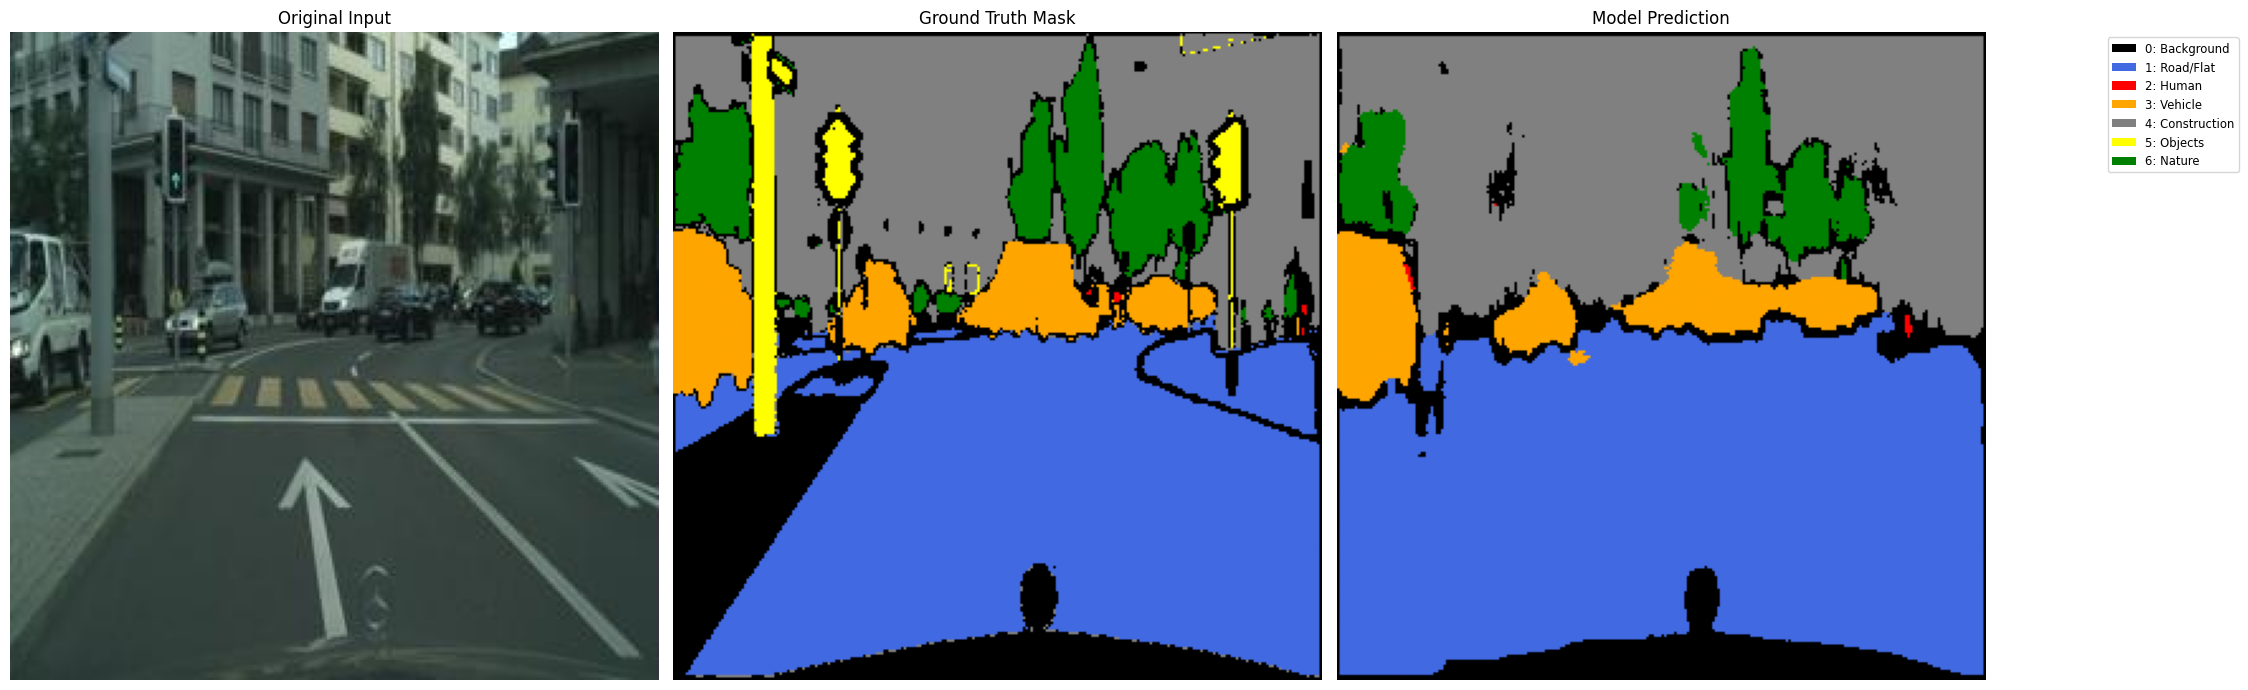

✅ Epoch 7 Completed | Avg Loss: 0.4080


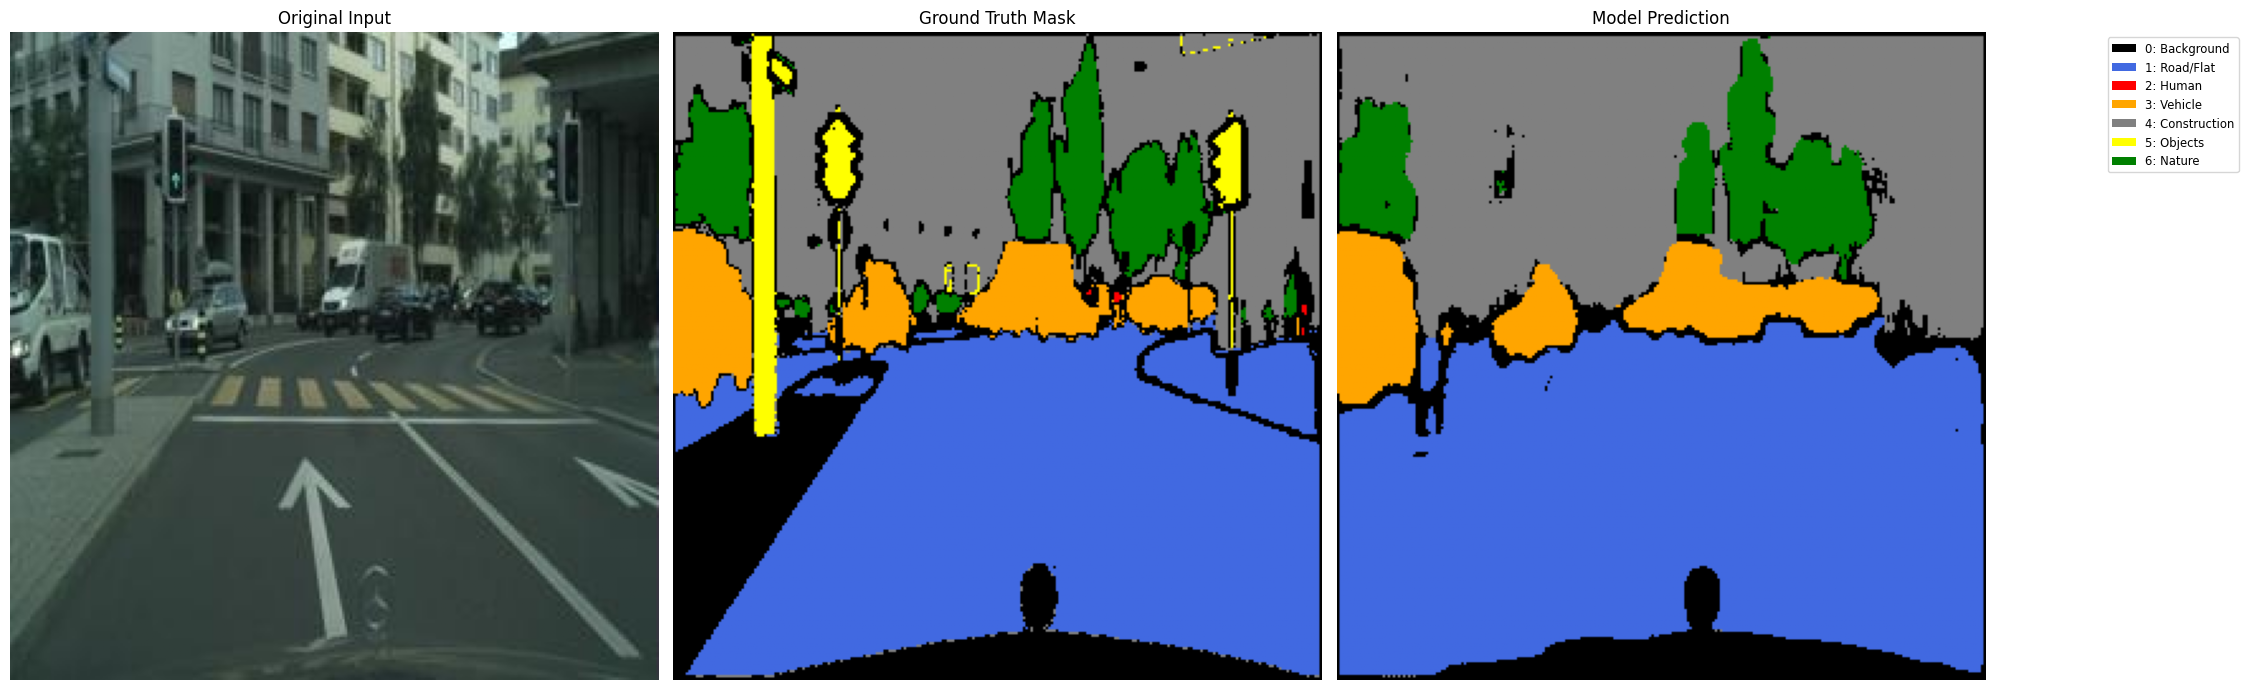

✅ Epoch 8 Completed | Avg Loss: 0.3964


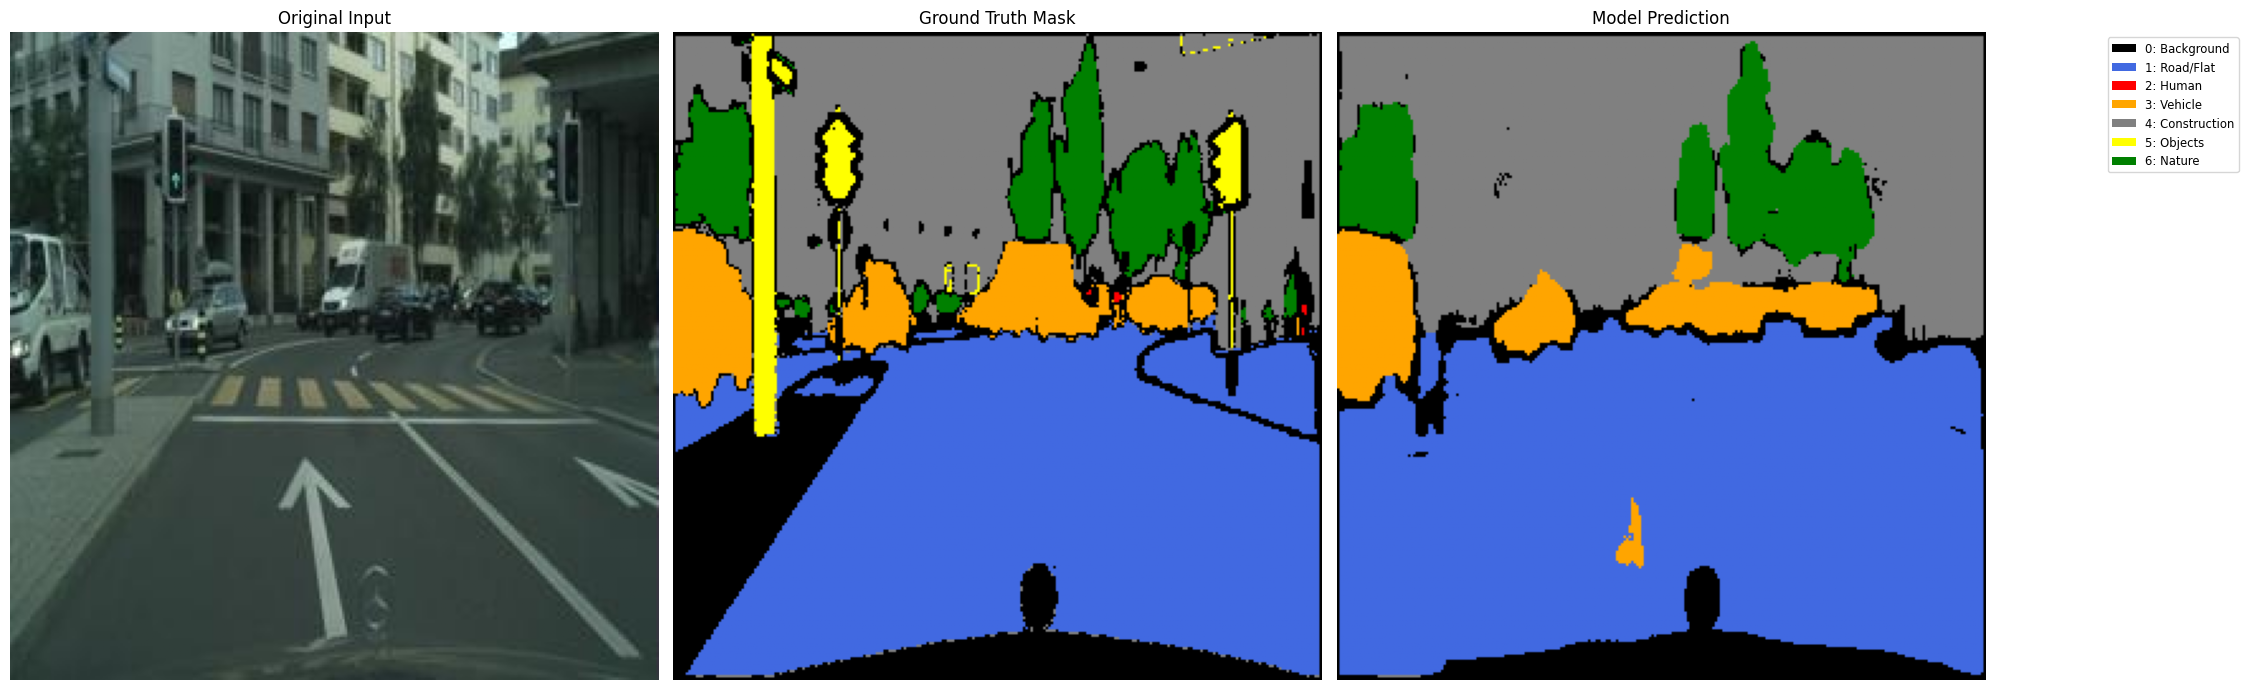

KeyboardInterrupt: 

In [4]:
# --- Step 5: Execute Training ---
model.train()
epoch_losses = []

print(f"Starting training for {EPOCHS} epochs on {device}...")

for epoch in range(EPOCHS):
    running_loss = 0.0
    loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    
    for i, (images, masks) in loop:
        images, masks = images.to(device), masks.to(device)

        # Forward Pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward Pass & Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"✅ Epoch {epoch+1} Completed | Avg Loss: {avg_loss:.4f}")

    # Visualize progress at the end of each epoch
    visualize_prediction(model, train_ds, index=10)

# Final step: Save weights
os.makedirs('../models', exist_ok=True)
torch.save(model.state_dict(), '../models/cityscapes_prototype_7class.pth')
print("🏁 Training Finished! Weights saved to ../models/cityscapes_prototype_7class.pth")